In [8]:
from datetime import datetime
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import subprocess
import moviepy.editor as mp
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import re
import random



In [14]:
def mmss_to_seconds(time_str):
    """Convert mm:ss format to seconds."""
    match = re.match(r"(\d+):(\d+)", time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    else:
        raise ValueError("Time format must be mm:ss")


def detect_audio_peaks(audio_path, start_time, end_time, sr=22050, hop_length=512):
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr, offset=start_time, duration=end_time - start_time)

    # Compute the onset envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # Detect peaks
    peak_indices = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, hop_length=hop_length)

    # Convert peak indices to time (in seconds)
    peak_times = librosa.frames_to_time(peak_indices, sr=sr, hop_length=hop_length)

    return peak_times


def detect_audio_peaks_with_fourier_transform(audio_path, start_time, end_time, sr=22050, hop_length=512, backtrack=True, plot=False):

    # Load audio
    y, sr = librosa.load(audio_path, sr=sr, offset=start_time, duration=end_time - start_time)

    # Compute STFT
    S = np.abs(librosa.stft(y, hop_length=hop_length))
    
    # Spectral flux
    flux = np.sqrt(np.sum(np.diff(S, axis=1)**2, axis=0))
    flux = np.pad(flux, (1, 0))  # match length

    # Normalize flux
    flux = (flux - np.min(flux)) / (np.max(flux) - np.min(flux) + 1e-6)

    # Onset envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    onset_env = (onset_env - np.min(onset_env)) / (np.max(onset_env) - np.min(onset_env) + 1e-6)

    # Combined novelty function
    combined_env = 0.5 * flux + 0.5 * onset_env

    # Detect peaks
    peak_indices = librosa.onset.onset_detect(onset_envelope=combined_env, sr=sr, hop_length=hop_length, backtrack=backtrack)
    peak_times = librosa.frames_to_time(peak_indices, sr=sr, hop_length=hop_length)

    # Plotting
    from matplotlib.lines import Line2D

    if plot:
        times = librosa.frames_to_time(np.arange(len(combined_env)), sr=sr, hop_length=hop_length)

        plt.figure(figsize=(14, 6))
        plt.plot(times, onset_env, label='Onset Envelope', alpha=0.7)
        plt.plot(times, flux, label='Spectral Flux', alpha=0.7)
        plt.plot(times, combined_env, label='Combined Signal', linewidth=2)

        for pt in peak_times:
            plt.axvline(x=pt, color='r', linestyle='--', alpha=0.6)

        # Create custom legend handle for the peak lines
        peak_legend = Line2D([0], [0], color='r', linestyle='--', alpha=0.6, label='Detected Peaks')

        plt.title('Peak Detection Debug Plot')
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Energy')
        plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [peak_legend], loc='upper right')
        plt.tight_layout()
        plt.show()

    return peak_times



#this function associates the images to the peaks in the audio file
def follow_the_peaks(image_folder, audio_path, output_video, start_time_str, end_time_str, fps=30):
    
    
    start_time = mmss_to_seconds(start_time_str)
    end_time = mmss_to_seconds(end_time_str)

    # Detect peaks in the audio file
    peak_times = detect_audio_peaks_with_fourier_transform(audio_path, start_time, end_time)

    
    images = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]
    random.shuffle(images) 

    if not images:
        raise ValueError("No images found in the specified folder.")

    if len(images) < len(peak_times):
        print(f"Warning: More peaks ({len(peak_times)}) detected than images ({len(images)}). Some images may repeat.")


    selected_images = []
    for i in range(len(peak_times)):
        selected_images.append(images[i % len(images)])  # Loop images if peaks > images

    
    clip = ImageSequenceClip(selected_images, durations=np.diff(np.append(peak_times, end_time - start_time)))
    audio = mp.AudioFileClip(audio_path).subclip(start_time, end_time)

    #attach audio to video
    clip = clip.set_audio(audio)

    clip.write_videofile(output_video, fps=fps)




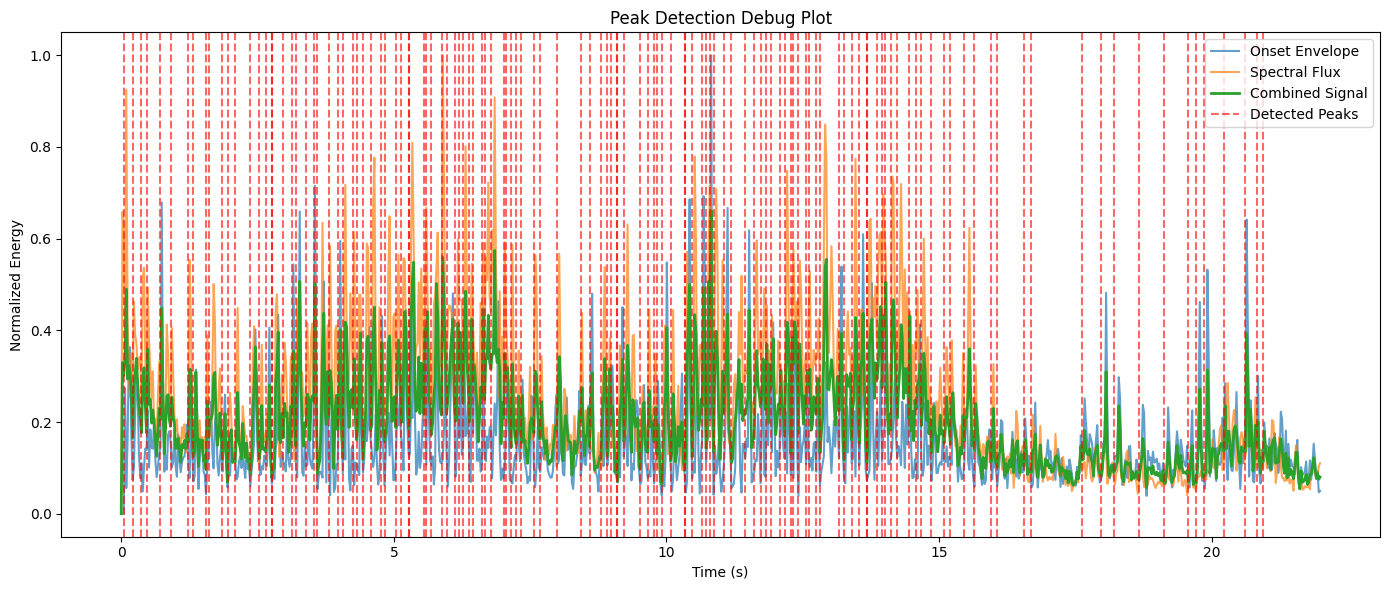

array([ 0.04643991,  0.20897959,  0.37151927,  0.46439909,  0.71981859,
        0.90557823,  1.2306576 ,  1.32353741,  1.55573696,  1.60217687,
        1.85759637,  1.95047619,  2.08979592,  2.36843537,  2.53097506,
        2.64707483,  2.7631746 ,  2.7631746 ,  2.9721542 ,  3.13469388,
        3.20435374,  3.39011338,  3.52943311,  3.59909297,  3.80807256,
        3.97061224,  4.06349206,  4.2492517 ,  4.31891156,  4.43501134,
        4.57433107,  4.7600907 ,  4.82975057,  5.03873016,  5.13160998,
        5.27092971,  5.27092971,  5.54956916,  5.59600907,  5.68888889,
        5.87464853,  5.96752834,  6.13006803,  6.19972789,  6.26938776,
        6.38548753,  6.45514739,  6.61768707,  6.66412698,  6.78022676,
        7.0124263 ,  7.05886621,  7.15174603,  7.24462585,  7.33750567,
        7.56970522,  7.68580499,  7.9876644 ,  8.42884354,  8.59138322,
        8.80036281,  8.91646259,  8.98612245,  9.10222222,  9.10222222,
        9.218322  ,  9.52018141,  9.65950113,  9.77560091,  9.82

In [15]:
start_time_str="2:54"  
end_time_str="3:16"  
start_time = mmss_to_seconds(start_time_str)
end_time = mmss_to_seconds(end_time_str)

detect_audio_peaks_with_fourier_transform("sources/audio/Hania_Rani_F_Major.mp3",  start_time, end_time, plot=True)


In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

follow_the_peaks(
        image_folder="results/maxxi_piano2",  
        audio_path="sources/audio/Hania_Rani_F_Major.mp3", 
        output_video=f"results/video/output_{timestamp}.mp4",  
        start_time_str="2:54",  
        end_time_str="3:16",  
        fps=30  
    )

Moviepy - Building video results/video/output_20250326_193703.mp4.
MoviePy - Writing audio in output_20250326_193703TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video results/video/output_20250326_193703.mp4



Moviepy - Done !
Moviepy - video ready results/video/output_20250326_193703.mp4
